# Predicting farm reciepts(revenue) from expenses using a Random Forest Regressor


In [28]:
# %pip install pandas numpy scikit-learn joblib openpyxl matplotlib seaborn notebook


In [29]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.inspection import permutation_importance

# helper functions
def _is_year(v):
    if isinstance(v, (int, float)) and not pd.isna(v):
        return 1900 <= int(v) <= 2100
    if isinstance(v, str):
        return bool(re.match(r"\d{4}", v))
    return False

def _find_year_row(df):
    for r in range(min(15, df.shape[0])):
        if sum(_is_year(x) for x in df.iloc[r, 1:15]) >= 3:
            return r
    raise ValueError("Year header row not found")

def _parse_years(row):
    yrs = []
    for v in row:
        if _is_year(v):
            yrs.append(int(re.match(r"(\d{4})", str(v)).group(1)) if isinstance(v, str) else int(v))
    return yrs

def parse_bea_sheet(df):
    yr_idx = _find_year_row(df)
    years = _parse_years(df.iloc[yr_idx, 1:].values)
    cols = [j for j in range(1, df.shape[1]) if _is_year(df.iloc[yr_idx, j])]
    start = yr_idx + 2
    data = {}
    for i in range(start, df.shape[0]):
        cat = df.iloc[i, 0]
        if isinstance(cat, str) and cat.strip() and not cat.lower().startswith("footnote"):
            vals = []
            for j in cols[:len(years)]:
                v = df.iloc[i, j]
                if isinstance(v, (int, float)):
                    vals.append(float(v))
                elif isinstance(v, str):
                    s = v.replace(",", "").replace("$", "").replace(" ", "").replace(" ", "")
                    try:
                        vals.append(float(s))
                    except ValueError:
                        vals.append(np.nan)
                else:
                    vals.append(np.nan)
            if not all(pd.isna(vals)):
                data[cat.strip().lower()] = vals
    return pd.DataFrame(data, index=years)


## Loading and cleansing of data

In [30]:
# Paths
INCOME_STATEMENT_FILE_PATH = "IncomeDataLarge_raw.xlsx"
EXPENSE_STATEMENT_FILE_PATH = "PE_State_US_raw.xlsx"

# load both files data
income_data_df = parse_bea_sheet(pd.read_excel(INCOME_STATEMENT_FILE_PATH, sheet_name="United States", header=None)).sort_index()
expenses_data_df = parse_bea_sheet(pd.read_excel(EXPENSE_STATEMENT_FILE_PATH, sheet_name="United States", header=None)).sort_index()

# use the features derived from EDA
expense_cols = [
    "seed",
    "fertilizer, lime, and soil conditioner",
    "fuel and oils",
    "electricity",
    "hired labor",
    "pesticide",
    "machine hire and custom work",
    "marketing, storage, and transportation",
    "nonreal estate interest",
]

expense_cols = [c for c in expense_cols if c in expenses_data_df.columns]
data = pd.concat([income_data_df["all commodity receipts"], expenses_data_df[expense_cols]], axis=1)
print(data.shape) # (116, 10)
y = data["all commodity receipts"]
X = data[expense_cols]


(116, 10)


## 5 fold cross validation

In [31]:

random_forest_model = RandomForestRegressor(n_estimators=500, random_state=0)
cross_val = KFold(n_splits=5, shuffle=True, random_state=0)
cross_val_r2 = cross_val_score(random_forest_model, X, y, cv=cross_val, scoring="r2")
print("5-fold cross_val R² scores:", np.round(cross_val_r2,5))
print("Mean cross_val R²:", cross_val_r2.mean())

'''
5-fold CV R² scores: [0.9868  0.99552 0.99016 0.98186 0.97024]
Mean CV R²: 0.9849168846162062
'''

# Fit full model
random_forest_model.fit(X, y)


5-fold cross_val R² scores: [0.99605 0.98859 0.99802 0.99347 0.98274]
Mean cross_val R²: 0.9917742254905818


RandomForestRegressor(n_estimators=500, random_state=0)

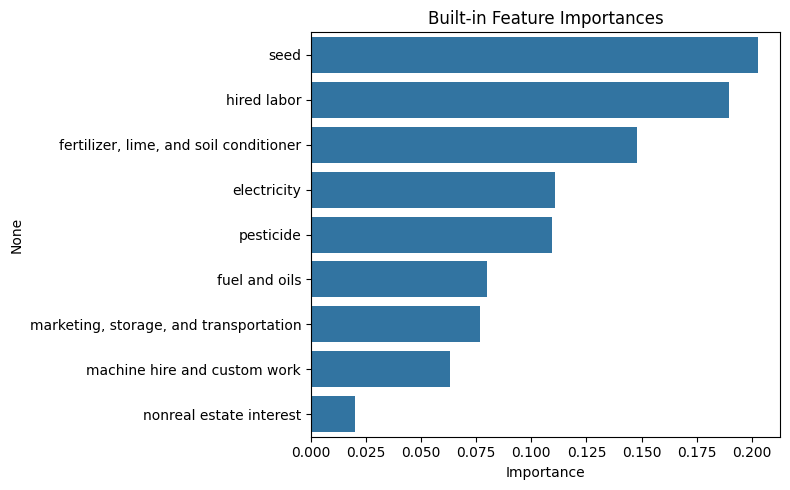

In [32]:
# feature importance plot 
importances = pd.Series(random_forest_model.feature_importances_, index=expense_cols).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=importances.values, y=importances.index)
plt.title('Built-in Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


## **Permutation importances** - done to measure the importance of each feature by seeing how much the model's performance degrades when that feature's values are randomly shuffled 

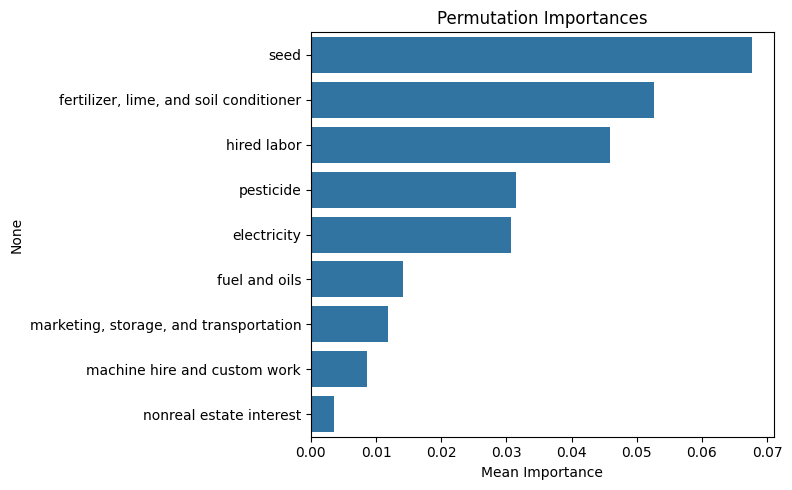

'\nMean Importance       Std\nseed                                           0.067648  0.006371\nfertilizer, lime, and soil conditioner         0.052705  0.004277\nhired labor                                    0.045946  0.004772\npesticide                                      0.031523  0.002725\nelectricity                                    0.030644  0.002615\nfuel and oils                                  0.014145  0.001229\nmarketing, storage, and transportation         0.011763  0.001179\nmachine hire and custom work                   0.008575  0.000879\nnonreal estate interest                        0.003616  0.000396\n'

In [36]:

perm = permutation_importance(random_forest_model, X, y, n_repeats=30, random_state=0)
perm_df = pd.DataFrame({
    'Mean Importance': perm.importances_mean,
    'Std': perm.importances_std
}, index=expense_cols).sort_values('Mean Importance', ascending=False)
# print(perm_df)

plt.figure(figsize=(8,5))
sns.barplot(x='Mean Importance', y=perm_df.index, data=perm_df)
plt.title('Permutation Importances')
plt.tight_layout()
plt.show()

'''
Mean Importance       Std
seed                                           0.067648  0.006371
fertilizer, lime, and soil conditioner         0.052705  0.004277
hired labor                                    0.045946  0.004772
pesticide                                      0.031523  0.002725
electricity                                    0.030644  0.002615
fuel and oils                                  0.014145  0.001229
marketing, storage, and transportation         0.011763  0.001179
machine hire and custom work                   0.008575  0.000879
nonreal estate interest                        0.003616  0.000396
'''

## Out Of Fold prediction (OOF-prediction) - Predict each data point using a model that never saw that point during training

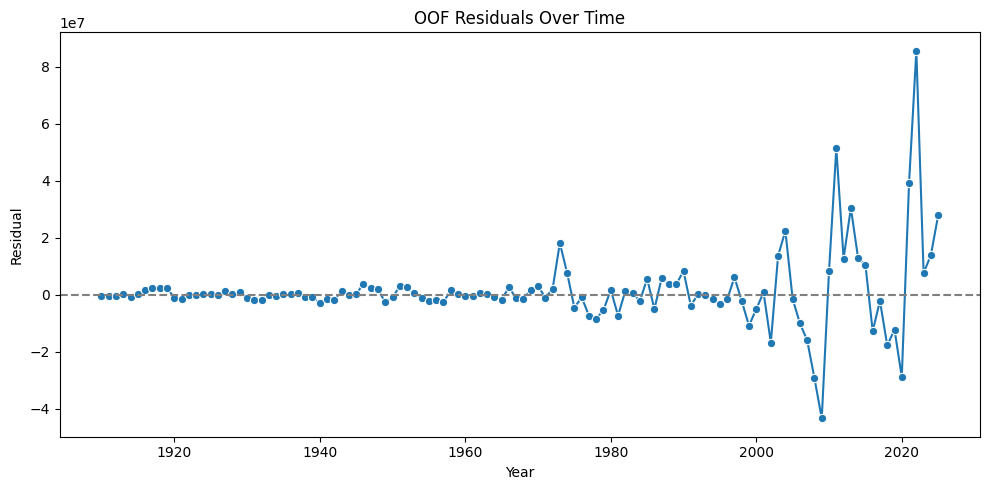

In [ ]:
oof_pred = cross_val_predict(random_forest_model, X, y, cv=cross_val)
res_oof = y - oof_pred
res_df = pd.DataFrame({'Year': data.index, 'Residual': res_oof})

plt.figure(figsize=(10,5))
sns.lineplot(x='Year', y='Residual', data=res_df, marker='o')
plt.axhline(0, linestyle='--', color='gray')
plt.title('OOF Residuals Over Time')
plt.tight_layout()
plt.show()
